In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Fri Jun 24 00:44:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 28%   36C    P8    22W / 260W |   3450MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# LDA

## 2018 brief paragraph

In [3]:
file_us = open("../LDA/segment/data/us_file_brief_paragraph_2018.txt", "r")
us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(us_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(10429 unique tokens: ['andor', 'article', 'barrier', 'comprise', 'comprises']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in us_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-6.659594,780.234331
1,3,-6.642623,767.104313
2,4,-6.623275,752.405253
3,5,-6.614677,745.963443
4,6,-6.612870,744.617054
5,7,-6.608261,741.192840
6,8,-6.610750,743.039884
7,9,-6.610128,742.578119
8,10,-6.604610,738.491710
9,11,-6.598672,734.119947


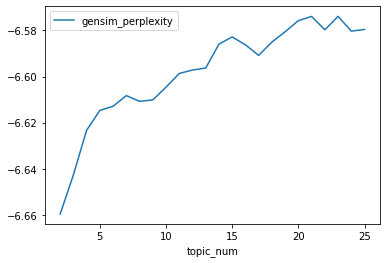

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-6.659594,780.234331
1,3,-6.642623,767.104313
2,4,-6.623275,752.405253
3,5,-6.614677,745.963443
4,6,-6.612870,744.617054
5,7,-6.608261,741.192840
6,8,-6.610750,743.039884
7,9,-6.610128,742.578119
8,10,-6.604610,738.491710
9,11,-6.598672,734.119947


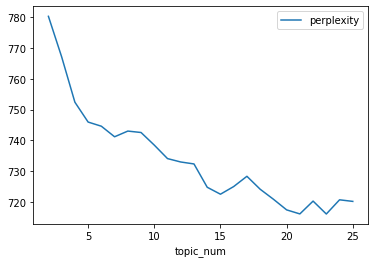

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_us_brief_paragraph_2018.csv", index=False)

## priority description sentence

In [11]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

10

In [23]:
topics_us = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_us.append(c.index(max(c)))

In [24]:
topics_us

[10,
 10,
 8,
 8,
 4,
 13,
 8,
 6,
 18,
 17,
 11,
 8,
 14,
 19,
 6,
 8,
 8,
 8,
 4,
 18,
 13,
 1,
 14,
 14,
 1,
 14,
 15,
 5,
 12,
 1,
 13,
 1,
 3,
 11,
 13,
 3,
 18,
 18,
 0,
 6,
 21,
 3,
 5,
 19,
 21,
 22,
 8,
 1,
 1,
 22,
 22,
 19,
 3,
 1,
 19,
 14,
 1,
 3,
 12,
 12,
 14,
 14,
 10,
 6,
 10,
 8,
 22,
 8,
 19,
 15,
 6,
 14,
 16,
 19,
 1,
 11,
 14,
 8,
 22,
 19,
 9,
 19,
 1,
 22,
 22,
 6,
 22,
 20,
 17,
 19,
 13,
 19,
 1,
 21,
 13,
 1,
 20,
 13,
 1,
 13,
 6,
 8,
 22,
 13,
 8,
 13,
 13,
 1,
 13,
 8,
 5,
 21,
 6,
 13,
 13,
 20,
 3,
 14,
 1,
 1,
 11,
 18,
 19,
 6,
 11,
 1,
 3,
 13,
 16,
 5,
 8,
 19,
 11,
 9,
 1,
 20,
 6,
 1,
 4,
 14,
 11,
 6,
 13,
 22,
 22,
 8,
 4,
 3,
 1,
 19,
 3,
 17,
 15,
 15,
 8,
 9,
 13,
 13,
 6,
 16,
 1,
 13,
 14,
 13,
 3,
 19,
 5,
 8,
 19,
 19,
 13,
 15,
 1,
 5,
 2,
 6,
 8,
 18,
 1,
 19,
 9,
 22,
 1,
 14,
 14,
 16,
 0,
 20,
 13,
 12,
 3,
 6,
 14,
 5,
 20,
 8,
 11,
 8,
 17,
 19,
 14,
 11,
 20,
 14,
 6,
 17,
 20,
 8,
 1,
 12,
 3,
 1,
 17,
 19,
 1,
 11,
 12,
 20,
 1,


In [25]:
print(len(topics_us))
print(len(us_desc))

7828
7828


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2018 = db.rm_patent_us_2018
    db_rm_us_2018 = db.rm_patent_us_2018
    # db_rm_de_2018 = db.rm_patent_de_2018
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_us_desc = db_rm_us_2018.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_us_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_us

,id,patentNumber,company,brief
0,62009a807b73c16636b31084,US20190027414A1,"[TERA-BARRIER FILMS Pte Ltd, Agency for Scienc...","Disclosed is an encapsulation barrier stack, c..."
1,6200a0367b73c16636b310c6,US20190156443A1,[Site 1001 Inc],A system and related method which has a databa...
2,6200a1047b73c16636b310d2,US20180310254A1,[Samsung Electronics Co Ltd],The present disclosure relates to a communicat...
3,6200b1ee7b73c16636b31104,US20180310259A1,"[Tigerconnect Inc, Samsung Electronics Co Ltd]",The present disclosure relates to a communicat...
4,6200b5587b73c16636b31136,US20190052993A1,[IoT Holdings Inc],A machine to machine (M2M) gateway (GW) compri...
...,...,...,...,...
7823,620b2b91e0ec9a30af2b7645,US20210400725A1,[NTT Docomo Inc],In order to perform appropriate communication ...
7824,620b2ba2e0ec9a30af2b765b,US20200202626A1,[Plantronics Inc],Methods and apparatuses for identifying and in...
7825,620b2bc1e0ec9a30af2b7663,US11140668B2,[AT&T Intellectual Property I LP],A base station device can transmit data via mu...
7826,620b2bc3e0ec9a30af2b7665,US10873773B2,[Cox Communications Inc],"Systems, methods and computer readable media f..."


In [30]:
print(len(df_us))
print(len(us_desc))

7828
7828


In [31]:
df_us["topic"]=topics_us

In [32]:
df_us

,id,patentNumber,company,brief,topic
0,62009a807b73c16636b31084,US20190027414A1,"[TERA-BARRIER FILMS Pte Ltd, Agency for Scienc...","Disclosed is an encapsulation barrier stack, c...",10
1,6200a0367b73c16636b310c6,US20190156443A1,[Site 1001 Inc],A system and related method which has a databa...,10
2,6200a1047b73c16636b310d2,US20180310254A1,[Samsung Electronics Co Ltd],The present disclosure relates to a communicat...,8
3,6200b1ee7b73c16636b31104,US20180310259A1,"[Tigerconnect Inc, Samsung Electronics Co Ltd]",The present disclosure relates to a communicat...,8
4,6200b5587b73c16636b31136,US20190052993A1,[IoT Holdings Inc],A machine to machine (M2M) gateway (GW) compri...,4
...,...,...,...,...,...
7823,620b2b91e0ec9a30af2b7645,US20210400725A1,[NTT Docomo Inc],In order to perform appropriate communication ...,20
7824,620b2ba2e0ec9a30af2b765b,US20200202626A1,[Plantronics Inc],Methods and apparatuses for identifying and in...,5
7825,620b2bc1e0ec9a30af2b7663,US11140668B2,[AT&T Intellectual Property I LP],A base station device can transmit data via mu...,20
7826,620b2bc3e0ec9a30af2b7665,US10873773B2,[Cox Communications Inc],"Systems, methods and computer readable media f...",14


In [33]:
df_us2 = df_us.explode('company')
df_us2

,id,patentNumber,company,brief,topic
0,62009a807b73c16636b31084,US20190027414A1,TERA-BARRIER FILMS Pte Ltd,"Disclosed is an encapsulation barrier stack, c...",10
0,62009a807b73c16636b31084,US20190027414A1,Agency for Science Technology and Research Sin...,"Disclosed is an encapsulation barrier stack, c...",10
1,6200a0367b73c16636b310c6,US20190156443A1,Site 1001 Inc,A system and related method which has a databa...,10
2,6200a1047b73c16636b310d2,US20180310254A1,Samsung Electronics Co Ltd,The present disclosure relates to a communicat...,8
3,6200b1ee7b73c16636b31104,US20180310259A1,Tigerconnect Inc,The present disclosure relates to a communicat...,8
...,...,...,...,...,...
7823,620b2b91e0ec9a30af2b7645,US20210400725A1,NTT Docomo Inc,In order to perform appropriate communication ...,20
7824,620b2ba2e0ec9a30af2b765b,US20200202626A1,Plantronics Inc,Methods and apparatuses for identifying and in...,5
7825,620b2bc1e0ec9a30af2b7663,US11140668B2,AT&T Intellectual Property I LP,A base station device can transmit data via mu...,20
7826,620b2bc3e0ec9a30af2b7665,US10873773B2,Cox Communications Inc,"Systems, methods and computer readable media f...",14


In [34]:
# 排名前16的公司
c_ls = list(df_us2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Telefonaktiebolaget LM Ericsson AB',
 'Intel Corp',
 'International Business Machines Corp',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Apple Inc',
 'Nokia Technologies Oy',
 'LG Electronics Inc',
 'Sony Corp',
 'Verizon Patent and Licensing Inc',
 'NEC Corp',
 'Amazon Technologies Inc',
 'AT&T Intellectual Property I LP',
 'Hewlett Packard Enterprise Development LP']

### 轉成company-topic 的總數表格

In [35]:
df_us_count = df_us2.groupby(["company","topic"],as_index=False).size()
df_us_count

,company,topic,size
0,0Chain LLC,19,1
1,2689090 Canada Inc,14,1
2,2you Io Inc,22,1
3,3M Innovative Properties Co,17,1
4,3M Innovative Properties Co,18,1
...,...,...,...
3164,Zuna Inc,6,1
3165,Zyter Inc,18,2
3166,eBay Inc,14,1
3167,eMemory Technology Inc,14,1


In [36]:
# 轉成company-topic 的總數表格
table_us = df_us_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_us = table_us.droplevel(level=0, axis=1)
table_us = table_us.rename(columns={'':'company'})

In [37]:
table_us

topic,company,0,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,21,22
0,0Chain LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2689090 Canada Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2you Io Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,3a Logics Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,Zuna Inc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1539,Zyter Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1540,eBay Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1541,eMemory Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
final_table_us = table_us[table_us.company.isin(c_ls)]
final_table_us

topic,company,0,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,21,22
26,AT&T Intellectual Property I LP,1.0,10.0,2.0,3.0,0.0,4.0,4.0,0.0,0.0,...,6.0,2.0,1.0,1.0,0.0,1.0,19.0,10.0,1.0,4.0
77,Amazon Technologies Inc,1.0,2.0,3.0,4.0,0.0,6.0,1.0,5.0,2.0,...,7.0,16.0,1.0,3.0,1.0,4.0,4.0,0.0,2.0,11.0
95,Apple Inc,4.0,63.0,3.0,4.0,0.0,0.0,3.0,0.0,10.0,...,3.0,1.0,2.0,2.0,3.0,0.0,6.0,23.0,2.0,1.0
248,Cisco Technology Inc,3.0,4.0,4.0,7.0,7.0,4.0,12.0,0.0,3.0,...,19.0,12.0,0.0,4.0,3.0,0.0,85.0,3.0,4.0,6.0
532,Hewlett Packard Enterprise Development LP,0.0,4.0,0.0,1.0,0.0,3.0,4.0,1.0,3.0,...,4.0,6.0,0.0,4.0,2.0,1.0,21.0,0.0,2.0,4.0
607,Intel Corp,8.0,67.0,3.0,18.0,2.0,6.0,21.0,4.0,21.0,...,9.0,28.0,9.0,21.0,30.0,10.0,22.0,28.0,4.0,29.0
617,International Business Machines Corp,4.0,2.0,4.0,23.0,4.0,22.0,33.0,3.0,9.0,...,30.0,36.0,12.0,11.0,3.0,16.0,17.0,4.0,6.0,27.0
707,LG Electronics Inc,2.0,59.0,0.0,0.0,0.0,1.0,1.0,0.0,8.0,...,1.0,1.0,3.0,0.0,2.0,6.0,1.0,23.0,2.0,2.0
808,Microsoft Technology Licensing LLC,1.0,2.0,1.0,8.0,5.0,7.0,12.0,5.0,2.0,...,16.0,30.0,2.0,4.0,2.0,4.0,15.0,3.0,4.0,10.0
840,NEC Corp,11.0,19.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,...,4.0,6.0,3.0,4.0,2.0,1.0,3.0,8.0,3.0,2.0


In [39]:
final_table_us.shape

(16, 24)

In [40]:
table_us.to_csv('company_lda_brief_us_2018.csv',index=0)